In [1]:
import numpy as np
from math import *

In [2]:
MAX_CARS = 20
MAX_MOVE_OF_CARS = 5
EXPECTED_FIRST_LOC_REQUESTS = 3
EXPECTED_SECOND_LOC_REQUESTS = 4
EXPECTED_FIRST_LOC_RETURNS = 3
EXPECTED_SECOND_LOC_RETURNS = 2
DISCOUNT_RATE = 0.9
RENTAL_CREDIT = 10
COST_OF_MOVING = 2
COST_OF_KEEPING = 4

In [3]:
policy = np.zeros((MAX_CARS+1, MAX_CARS+1))
stateVal = np.zeros((MAX_CARS+1, MAX_CARS+1))

In [4]:
states = []
for i in range(MAX_CARS+1):
    for j in range(MAX_CARS+1):
        states.append([i,j])

In [5]:
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS+1)

In [6]:
pBackup = dict()

def poisson(x, lam):
    global pBackup
    key = x*10 + lam
    if key not in pBackup.keys():
        pBackup[key] = np.exp(-lam) * pow(lam,x) / factorial(x)
    return pBackup[key]

In [7]:
POISSON_UPPER_BOUND = 11

In [8]:
newStateVal = np.zeros((MAX_CARS+1, MAX_CARS+1))
improvePolicy = False
policyStable = False

In [9]:
def expectedReturn(state, action, stateValue):
    # Initiate and populate returns with cost associated with moving cars
    returns = 0.0
    # Account for the employee that moves a car from loc 1 to loc 2 for free
    if action > 0:
        action_prime = action - 1
    else:
        action_prime = action
    returns -= COST_OF_MOVING * np.absolute(action_prime)
    # Number of cars to start the day
    carsLoc1 = int(min(state[0] - action, MAX_CARS))
    carsLoc2 = int(min(state[1] + action, MAX_CARS))
    # Additional cost for keeping more than 10 cars overnight at a location
    returns -= (int(max(0, carsLoc1-10)) + int(max(0, carsLoc2-10))) * COST_OF_KEEPING
    # Iterate over Rental Rates
    for rentalsLoc1 in range(0, POISSON_UPPER_BOUND):
        for rentalsLoc2 in range(0, POISSON_UPPER_BOUND):
            # Rental Probabilities
            rentalsProb = poisson(rentalsLoc1, EXPECTED_FIRST_LOC_REQUESTS) * poisson(rentalsLoc2, EXPECTED_SECOND_LOC_REQUESTS)
            # Total Rentals
            totalRentalsLoc1 = min(carsLoc1, rentalsLoc1)
            totalRentalsLoc2 = min(carsLoc2, rentalsLoc2)
            # Total Rewards
            rewards = (totalRentalsLoc1 + totalRentalsLoc2) * RENTAL_CREDIT
            # Iterate over Return Rates
            for returnsLoc1 in range(0, POISSON_UPPER_BOUND):
                for returnsLoc2 in range(0, POISSON_UPPER_BOUND):
                    # Return Rate Probabilities
                    prob = poisson(returnsLoc1, EXPECTED_FIRST_LOC_RETURNS) * poisson(returnsLoc2, EXPECTED_SECOND_LOC_RETURNS) * rentalsProb
                    # Number of cars at the end of the day
                    carsLoc1_prime = min(carsLoc1 - totalRentalsLoc1 + returnsLoc1, MAX_CARS)
                    carsLoc2_prime = min(carsLoc2 - totalRentalsLoc2 + returnsLoc2, MAX_CARS)
                    # Number of cars at the end of the day
                    returns += prob * (rewards + DISCOUNT_RATE * stateValue[carsLoc1_prime, carsLoc2_prime])
    return returns

In [10]:
k = 0
policy_list = [policy]

while policyStable == False:
    ## Policy Evaluation
    print("Policy Eval")
    for i,j in states:
        newStateVal[i,j] = expectedReturn([i,j], policy[i,j], stateVal)
    print(np.max(np.absolute(newStateVal-stateVal)))
    if np.max(np.absolute(newStateVal-stateVal)) < 1e-4:
        print("Almost converged")
        improvePolicy = True
    
    stateVal = newStateVal.copy()

    ## Policy Improvement
    if improvePolicy == True:
        print("Improve Policy: ", k)
        newPolicy = np.zeros((MAX_CARS+1, MAX_CARS+1))
        for i,j in states:
            actionReturns = []
            for action in actions:
                if ((action >= 0) and (i >= action)) or ((action < 0) and j >= np.absolute(action)):
                    actionReturns.append(expectedReturn([i,j], action, stateVal))
                else:
                    actionReturns.append(-float('inf'))
            bestAction = np.argmax(actionReturns)
            newPolicy[i,j] = actions[bestAction]
        policyChanges = np.sum(newPolicy != policy)


        if policyChanges == 0:
            policyStable = True
        else:
            policy = newPolicy
            improvePolicy = False
            policy_list.append(policy)


        k += 1
    
# exec time: 52 min

Policy Eval
69.52403001982688
Policy Eval
58.49211926107057
Policy Eval
48.91473772448843
Policy Eval
41.531351389658
Policy Eval
35.862123033416935
Policy Eval
31.47091213671189
Policy Eval
27.85918725306891
Policy Eval
24.337061923671826
Policy Eval
21.04785309848799
Policy Eval
18.16360398900079
Policy Eval
15.709386824496761
Policy Eval
13.643749094115151
Policy Eval
11.905121700769598
Policy Eval
10.433455935112647
Policy Eval
9.177930749200527
Policy Eval
8.09811779866044
Policy Eval
7.162648665515462
Policy Eval
6.347283151871409
Policy Eval
5.633131465372458
Policy Eval
5.005246570702525
Policy Eval
4.451585148370327
Policy Eval
3.9622664650853494
Policy Eval
3.529050707210274
Policy Eval
3.1449713554737286
Policy Eval
2.804073010889681
Policy Eval
2.5012207021537165
Policy Eval
2.23195772608625
Policy Eval
1.9923968049535006
Policy Eval
1.7791345480386553
Policy Eval
1.5891826200552828
Policy Eval
1.419911228478611
Policy Eval
1.2690019629787344
Policy Eval
1.1344079340809117


In [13]:
np.save("/system/user/studentwork/mederits/Research/RL/Policy_Iteration/jacks_car_rental_policy_GPI_two_array_version_exercise.npy", policy)

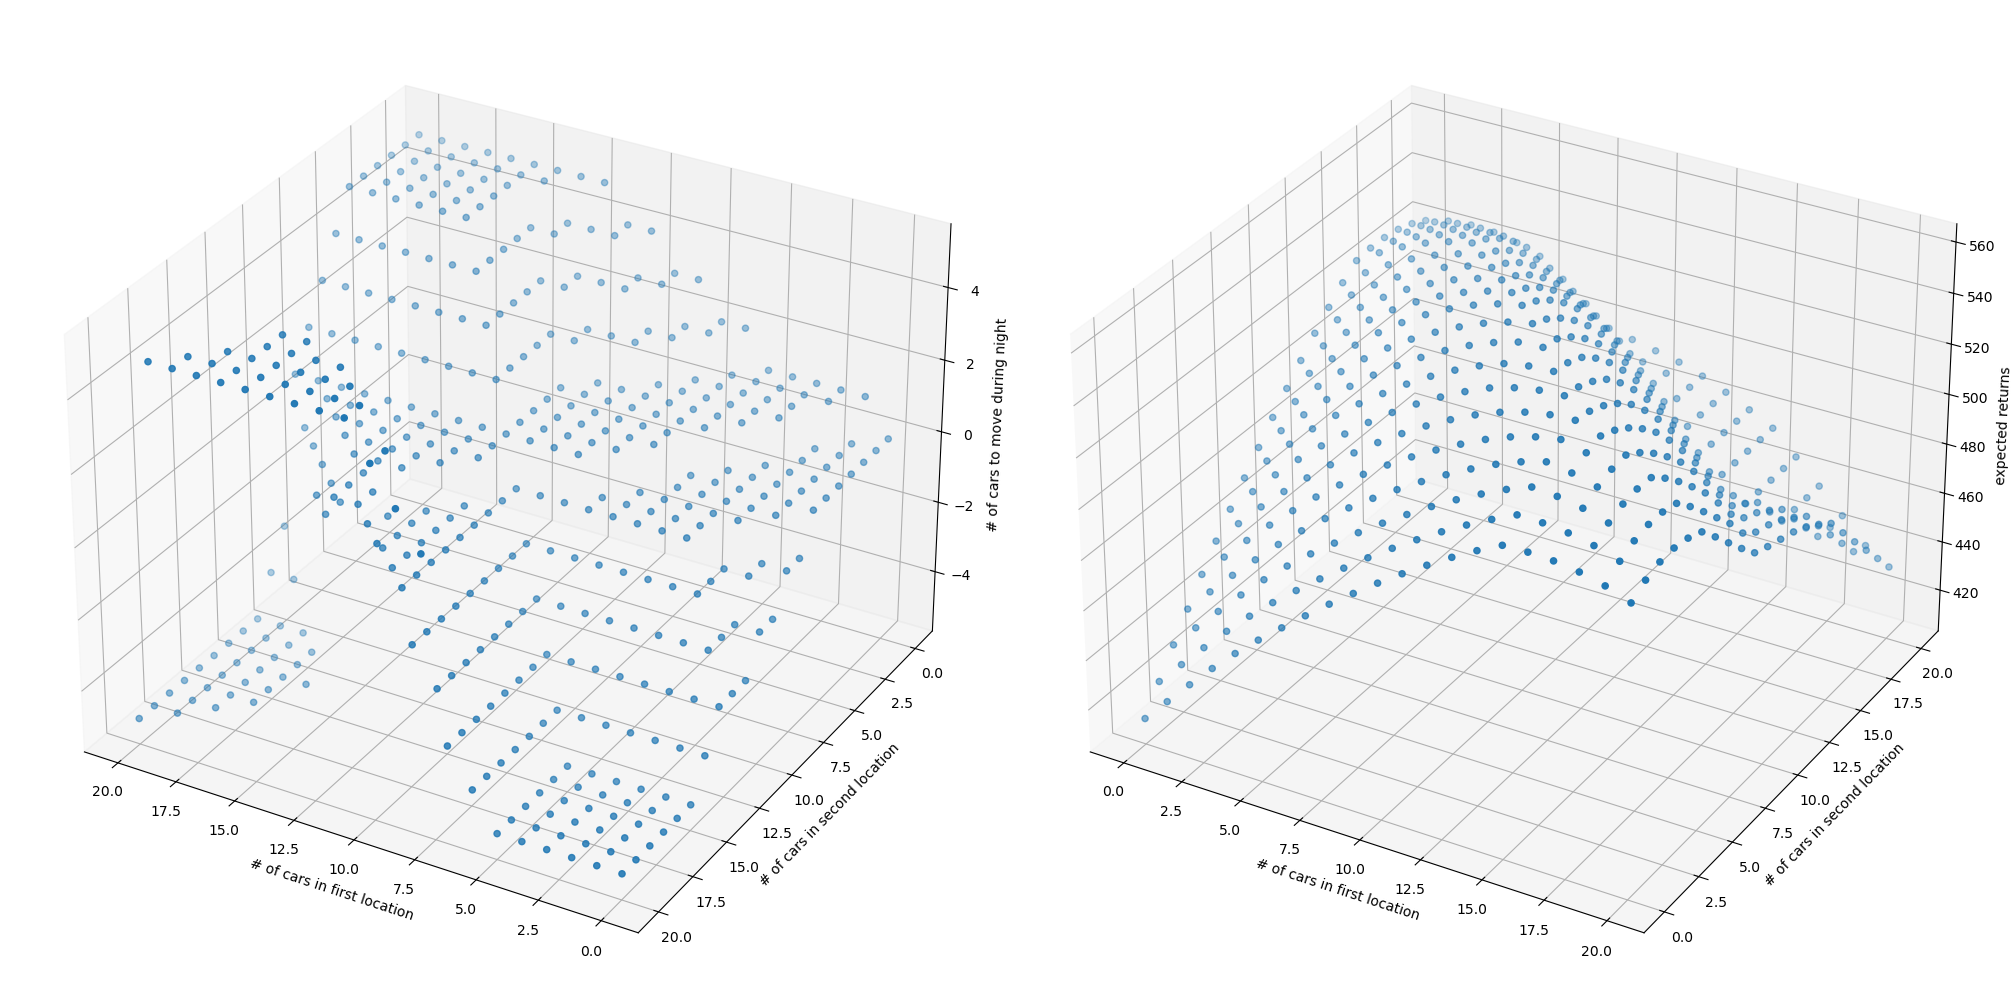

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure(figsize=(20,10), layout="constrained")
ax = fig.add_subplot(1,2,1, projection='3d')

m = 'o'

cars_loc1 = []
cars_loc2 = []
policy_list = []
value_list = []

for i,j in states:
    cars_loc1.append(i)
    cars_loc2.append(j)
    policy_list.append(policy[i,j])
    value_list.append(stateVal[i,j])

ax.scatter(cars_loc1, cars_loc2, policy_list, marker=m)

ax.set_xlabel('# of cars in first location')
ax.set_ylabel('# of cars in second location')
ax.set_zlabel('# of cars to move during night')

ax.xaxis.set_inverted(True)
ax.yaxis.set_inverted(True)

ax2 = fig.add_subplot(1,2,2, projection='3d')

ax2.scatter(cars_loc1, cars_loc2, value_list, marker=m)

ax2.set_xlabel('# of cars in first location')
ax2.set_ylabel('# of cars in second location')
ax2.set_zlabel('expected returns')

ax2.xaxis.set_inverted(False)
ax2.yaxis.set_inverted(False)

plt.show()

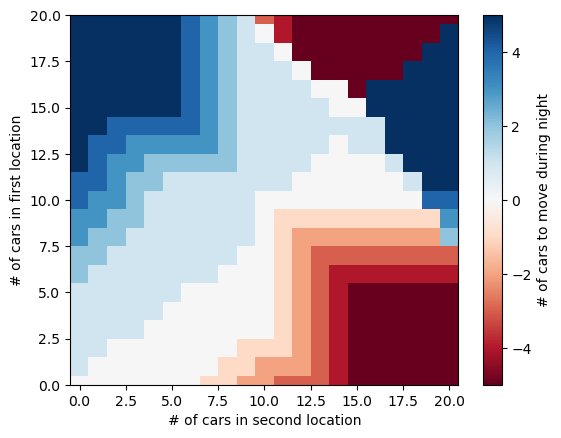

In [12]:
plt.imshow(policy, cmap='RdBu', interpolation='nearest')
plt.ylim([0,20])
cbar = plt.colorbar()
cbar.set_label('# of cars to move during night', rotation=90)


plt.xlabel("# of cars in second location")
plt.ylabel("# of cars in first location")
plt.show()